<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Merging the datasets
</h1>

In [57]:
%pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [58]:
#important libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import skfuzzy as fuzz

%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [ ]:
# Load the datasets after EDA
df_flights_eda = pd.read_csv('DM_AIAI_FlightsDB_after_eda.csv') 
df_costumers_eda = pd.read_csv('DM_AIAI_CustomersDB_after_eda.csv')

In [60]:
df_flights_eda.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,PointsRedeemRatio,FlightsWithCompanionsRatio
0,100018,225,45,53014.30,20562.8,10.184290,6.911549
1,100102,245,55,33903.96,18760.6,22.598836,7.028860
2,100140,211,51,43192.58,4896.0,2.902193,9.935897
3,100214,108,17,36453.77,12908.6,47.362033,7.571429
4,100272,181,50,42953.25,10891.4,5.613796,9.002997


In [61]:
df_costumers_eda.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [62]:
df_costumers_eda.drop(columns=['Unnamed: 0'], inplace=True) #dropping de 'Unnamed: 0' column

In [63]:
merged_df = df_flights_eda.merge(df_costumers_eda, on="Loyalty#", how = "inner" ) #merging both datasets

In [64]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,PointsRedeemRatio,FlightsWithCompanionsRatio,First Name,Last Name,Customer Name,...,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,100018,225,45,53014.30,20562.8,10.184290,6.911549,Mina,Smida,Mina Smida,...,female,Bachelor,Rural,82877.0,Married,Aurora,8/9/2019,NaN,7919.20,Standard
1,100102,245,55,33903.96,18760.6,22.598836,7.028860,Rigoberto,Palacio,Rigoberto Palacio,...,male,College,Urban,0.0,Single,Nova,3/9/2016,NaN,2887.74,Standard
2,100140,211,51,43192.58,4896.0,2.902193,9.935897,Nakesha,Klaass,Nakesha Klaass,...,female,College,Suburban,0.0,Divorced,Nova,7/30/2019,NaN,2838.07,Standard
3,100214,108,17,36453.77,12908.6,47.362033,7.571429,Loren,Juenemann,Loren Juenemann,...,male,Bachelor,Suburban,42837.0,Married,Star,8/6/2018,NaN,4170.57,Standard
4,100272,181,50,42953.25,10891.4,5.613796,9.002997,Siobhan,Lander,Siobhan Lander,...,female,Bachelor,Suburban,80979.0,Divorced,Star,1/9/2017,NaN,6622.05,Standard


In [65]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,PointsRedeemRatio,FlightsWithCompanionsRatio,First Name,Last Name,Customer Name,...,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,100018,225,45,53014.30,20562.8,10.184290,6.911549,Mina,Smida,Mina Smida,...,female,Bachelor,Rural,82877.0,Married,Aurora,8/9/2019,NaN,7919.20,Standard
1,100102,245,55,33903.96,18760.6,22.598836,7.028860,Rigoberto,Palacio,Rigoberto Palacio,...,male,College,Urban,0.0,Single,Nova,3/9/2016,NaN,2887.74,Standard
2,100140,211,51,43192.58,4896.0,2.902193,9.935897,Nakesha,Klaass,Nakesha Klaass,...,female,College,Suburban,0.0,Divorced,Nova,7/30/2019,NaN,2838.07,Standard
3,100214,108,17,36453.77,12908.6,47.362033,7.571429,Loren,Juenemann,Loren Juenemann,...,male,Bachelor,Suburban,42837.0,Married,Star,8/6/2018,NaN,4170.57,Standard
4,100272,181,50,42953.25,10891.4,5.613796,9.002997,Siobhan,Lander,Siobhan Lander,...,female,Bachelor,Suburban,80979.0,Divorced,Star,1/9/2017,NaN,6622.05,Standard


In [ ]:
merged_df["EnrollmentDateOpening"] = pd.to_datetime(merged_df["EnrollmentDateOpening"])
merged_df["Enroll_Year"] = merged_df["EnrollmentDateOpening"].dt.year
merged_df["Enroll_Month"] = merged_df["EnrollmentDateOpening"].dt.month

'\nmerged_df["Tenure_Days"] = (\n    merged_df["CancellationDate"] - merged_df["EnrollmentDateOpening"]\n).dt.days\n'

In [67]:
merged_df.dtypes

Loyalty#                               int64
NumFlights                             int64
NumFlightsWithCompanions               int64
PointsAccumulated                    float64
PointsRedeemed                       float64
PointsRedeemRatio                    float64
FlightsWithCompanionsRatio           float64
First Name                            object
Last Name                             object
Customer Name                         object
Country                               object
Province or State                     object
City                                  object
Latitude                             float64
Longitude                            float64
Postal code                           object
Gender                                object
Education                             object
Location Code                         object
Income                               float64
Marital Status                        object
LoyaltyStatus                         object
Enrollment

In [69]:
merged_df.dtypes

Loyalty#                               int64
NumFlights                             int64
NumFlightsWithCompanions               int64
PointsAccumulated                    float64
PointsRedeemed                       float64
PointsRedeemRatio                    float64
FlightsWithCompanionsRatio           float64
First Name                            object
Last Name                             object
Customer Name                         object
Country                               object
Province or State                     object
City                                  object
Latitude                             float64
Longitude                            float64
Postal code                           object
Gender                                object
Education                             object
Location Code                         object
Income                               float64
Marital Status                        object
LoyaltyStatus                         object
Enrollment

In [70]:
#Splitting diferent features into categorical and numerical
numerical = ['Loyalty#', 'NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated','PointsRedeemed',
             'PointsRedeemRatio', 'FlightsWithCompanionsRatio','Latitude', 'Longitude', 'Income', 'Customer Lifetime Value',
             'Enroll_Year', 'Enroll_Month']

categorical = ['Province or State', 'City', 'Postal code', 'Education', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType', 'EnrollmentDateOpening', 'CancellationDate']

In [71]:
X_cat = OneHotEncoder(sparse_output=False).fit_transform(merged_df[categorical])
X_num = StandardScaler().fit_transform(merged_df[numerical])

Now that we finished merging our datasets, we are ready to start testing the diferent types of clustering methods, in this project we will test, Agglomerative, K-means and Fuzzy Clustering.

<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Clustering
</h1>

### Agglomerative Clustering

In [72]:
X = np.hstack([X_num, X_cat])
Z = linkage(X, method="ward")

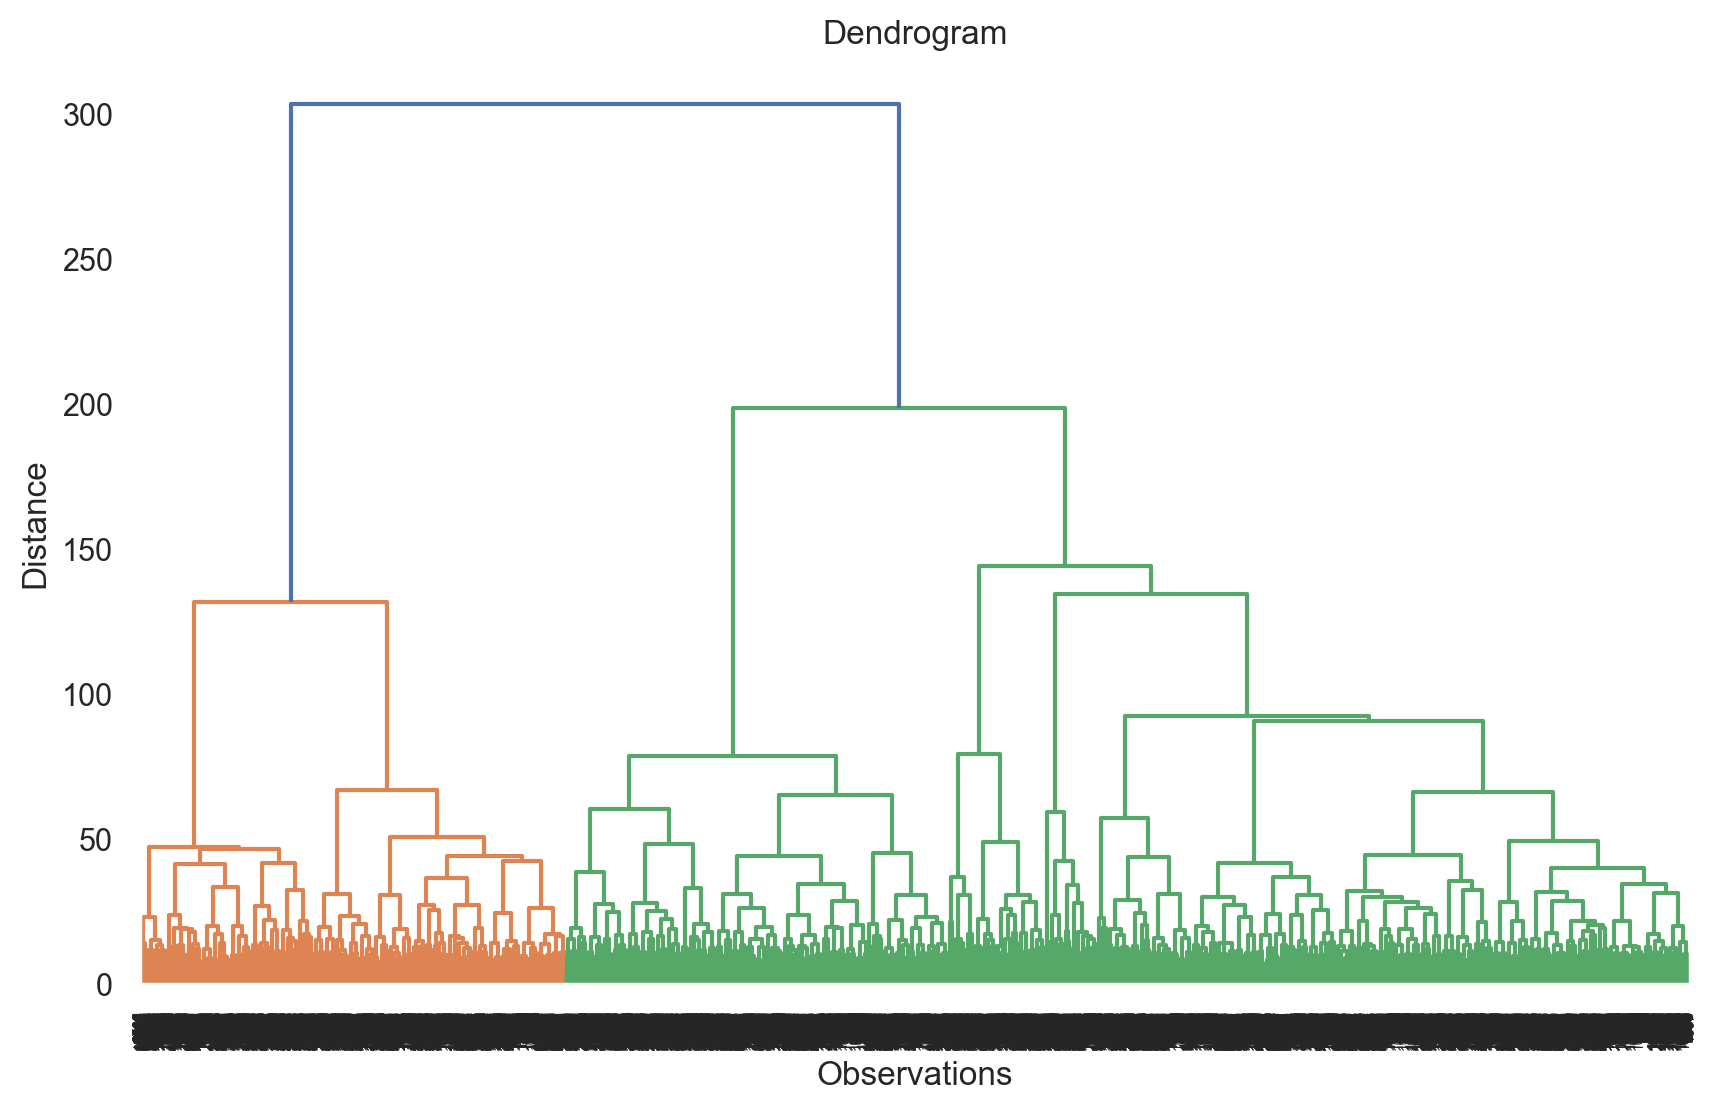

In [73]:
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

Determination of the Optimal Number of Clusters Using a Dendrogram:

The hierarchical clustering structure was analyzed using a dendrogram in order to determine the optimal number of clusters. The dendrogram represents the successive merging of observations based on their linkage distances.

A clear and substantial increase in linkage distance is observed at the final merge (from two clusters to one), which suggests that combining these two groups would result in the aggregation of highly dissimilar clusters. According to standard hierarchical clustering criteria, this indicates that **two clusters** provide the strongest overall separation and represent the most robust solution.

However, an earlier but still significant increase in linkage distance can be identified at an intermediate level, approximately between distances of 130 and 200. Cutting the dendrogram at this level yields **three clusters**, which remain well separated and internally coherent.

In summary:
- **Two clusters** offer the simplest and most robust partition, maximizing separation between groups.
- **Three clusters** provide a more granular and informative segmentation while maintaining meaningful inter-cluster distances.

Therefore, while two clusters represent the primary choice based on the largest distance jump, **three clusters also constitute a valid and justifiable alternative**, particularly when a more detailed cluster interpretation is desired. Let's test with 2 and 3 clusters and compare the results.


In [ ]:
#3 cluster solution
hc3 = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward',
    metric='euclidean'
)

labels_hc3 = hc3.fit_predict(X)

In [ ]:
#2 cluster solution
hc2_clust = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
hc2_labels = hc2_clust.fit_predict(X)

In [ ]:

pd.crosstab(
    pd.Series(labels_hc3, name='hc3_labels', index=merged_df.index),
    pd.Series(hc2_labels, name='hc2_labels', index=merged_df.index),
    )

NameError: name 'hc2_labels' is not defined

### KMeans


In [75]:

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


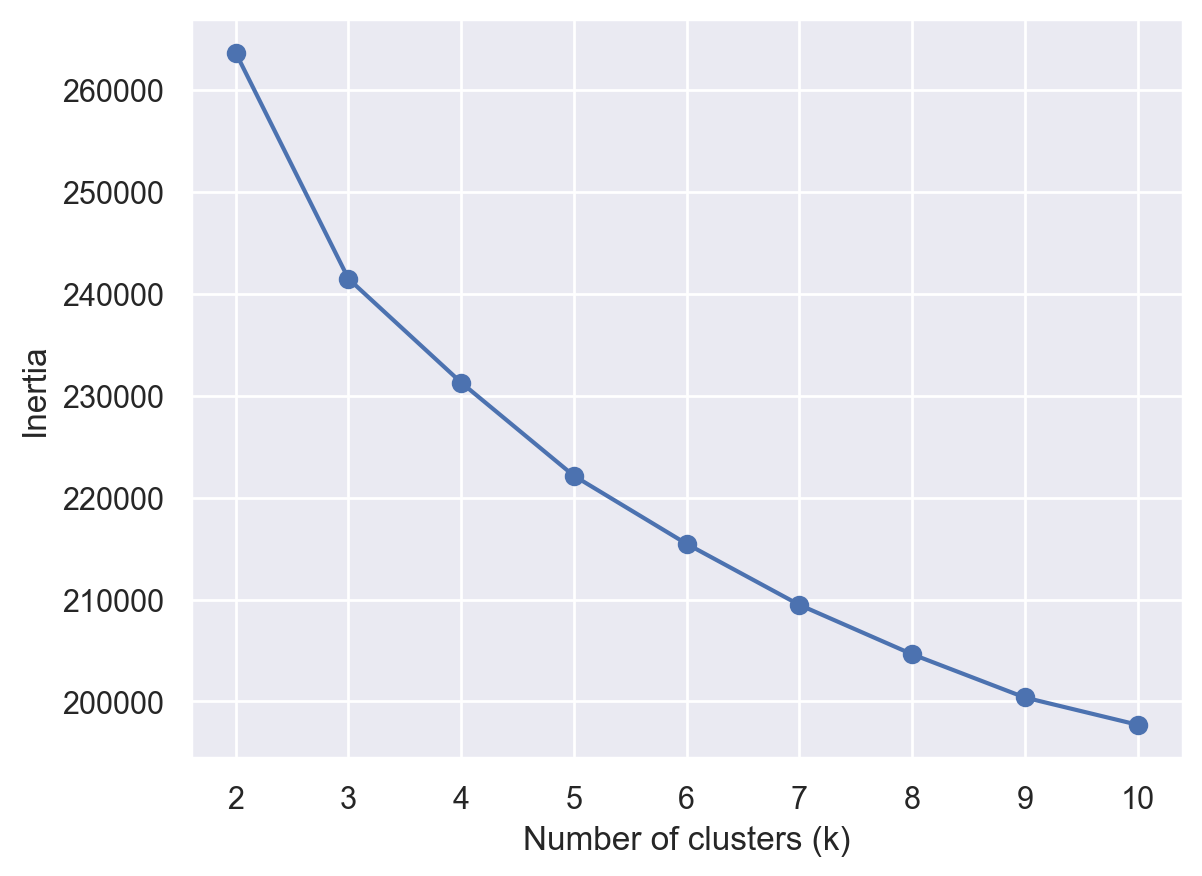

In [76]:
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

Selection of the Optimal Number of Clusters:

To determine the optimal number of clusters, the **elbow method** was applied. This method involves plotting the within-cluster sum of squares (inertia) against the number of clusters \(k\) and identifying the point where the decrease in inertia begins to slow down significantly.

From the analysis of the inertia curve, there is a substantial reduction in inertia when increasing the number of clusters from \(k = 2\) to \(k = 4\). After \(k = 4\), the curve flattens, indicating that adding more clusters results in only marginal improvements.

Therefore, the “elbow” of the curve is identified at \(k = 4\). Based on this criterion, **four clusters** were selected as the optimal number, representing a good trade-off between model complexity and clustering performance.


In [77]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)


### Fuzzy Clustering

In [78]:
X_cat = X_cat.copy()
X_num = X_num.copy()

XX = np.hstack([X_num, X_cat])

In [ ]:
X_fuzzy = XX.T

n_clusters = 4

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_fuzzy,
    c=n_clusters,
    m=2.0,    
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)


In [80]:
fpc_values = []

for c in range(2, 8):
    _, _, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_fuzzy, c=c, m=2, error=0.005, maxiter=500
    )
    fpc_values.append(fpc)


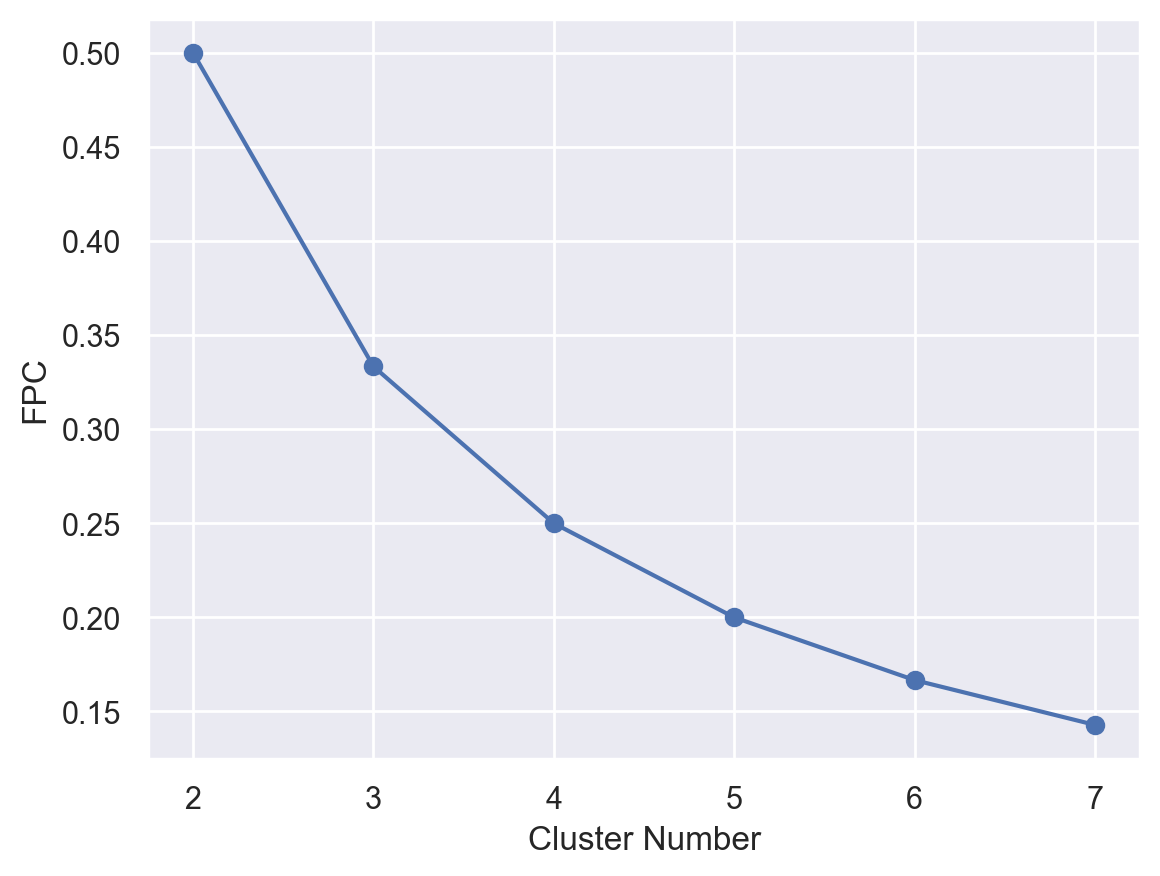

In [81]:
plt.plot(range(2, 8), fpc_values, marker="o")
plt.xlabel("Cluster Number")
plt.ylabel("FPC")
plt.show()


### Comparing different types of clusters

In [82]:
merged_df['cluster'] = labels_hc
merged_df["Kmeans"] = kmeans.fit_predict(X)
merged_df["FuzzyCluster"] = np.argmax(u, axis=0)
merged_df["Membership_Strength"] = np.max(u, axis=0)

In [83]:
cluster_comparison = pd.DataFrame({
    'Hierarchical': merged_df['cluster'], 'KMeans': merged_df['Kmeans'], 'Fuzzy': merged_df['FuzzyCluster']
})

In [84]:
cluster_comparison

,Hierarchical,KMeans,Fuzzy
0,2,3,1
1,0,1,1
2,2,3,1
3,2,3,1
4,0,1,1
...,...,...,...
16896,0,1,1
16897,1,2,2
16898,1,2,2
16899,1,0,2
